In [1]:
from jqdata import *
# 使用因子分析进行计算
import pandas as pd
import numpy as np
import talib
import pickle
from tqdm import *
import itertools
import matplotlib.pyplot as plt
import matplotlib.dates as mdate

# 设置字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# 图表主题
plt.style.use('seaborn')

# 传统均线系统

跟随市场趋势是一种简单有效的投资方式。在市场处于上升趋势时，投资者可以买入并持有；当市场转为下降趋势时，投资者可以选择卖空或空仓。

跟随趋势最简单的办法是采用移动平均（Moving Average）线,其算法为：

$MA(n) = \frac{1}{n}\sum^{n-1}_{i=0}price(T-i)$

其中 price一般选择收盘价,MA(n)即为T日的n日均线指标。对于MA指标，n越大，趋势线的平滑性越好。 MA指标可以很好地刻画指数或股票价格趋势，但其最大的问题在于存在延迟。

如下图所示的指数日线及 MA 均线系统，蓝色、橙色、紫色、绿色分别代表 5 日、 10 日、30 日和 60 日均线。可以看出，随着均线分母n的增加，MA 指标的局部波动显著减小（即平滑性越来越好），但趋势跟随也出现了越来越高的延迟。

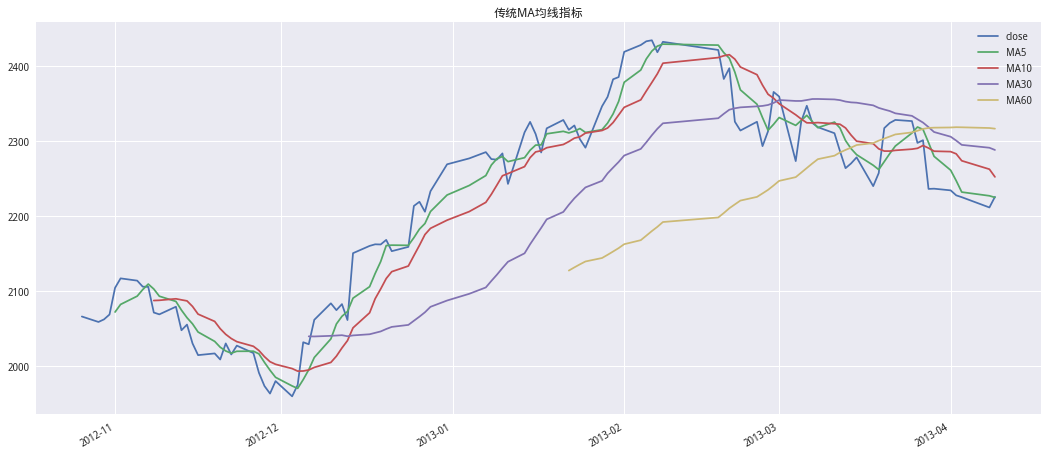

In [2]:
# 获取上证指数
price_df = get_price('000001.XSHG',start_date='2012-10-26',end_date='2013-04-09',fields='close')

for i in [5,10,30,60]:
    price_df[f'MA%d'%i] = price_df['close'].rolling(i).mean()
    
plt.rcParams['font.family']='serif'
price_df.plot(figsize=(18,8),title='传统MA均线指标')

因此，在使用 MA 指标进行趋势跟踪时，容易出现“跟不紧”甚至“跟不上”的 情况。本篇低延迟趋势线 LLT 指标（Low-lag Trendline），通过信号处理理论中的一些滤波方法，克服了 MA 指标的上述缺点，可以实现低延迟趋势跟踪。

# 低延迟趋势线 LLT 的构造

具体理论部分跳过，这里直接给出构造方法

<font size=4>$\frac{LLT(z)}{price(z)}=\frac{(\alpha-\alpha^2/4)+(\alpha^2/2)z^{-1}-(\alpha-3\alpha^2/4)z^{-2}}{1-2(1-\alpha)z^{-1}+(1-\alpha)^2z^{-2}}$</font>

公式换成人话：
$LLT = (\alpha-\alpha^2/4)*price_T+(\alpha^2/2)*price_{T-1}-(\alpha-3\alpha^2/4)*price_{T-2}+2(1-\alpha)*LLT_{T-1}-(1-\alpha)^2*LLT_{T-2}$

In [2]:
def cal_LLT(price: pd.Series, alpha: float):

    LLT = []
    price_value = price.values
    LLT.append(price_value[0])
    LLT.append(price_value[1])


    for i, e in enumerate(price_value):
        if i > 1:

            v = (alpha - alpha**2 / 4) * e + (alpha**2 / 2) * price_value[i - 1] - (
                alpha - 3 * (alpha**2) / 4) * price_value[i - 2] + 2 * (
                    1 - alpha) * LLT[i - 1] - (1 - alpha)**2 * LLT[i - 2]

            LLT.append(v)

    return LLT

In [4]:
# 获取上证指数
price_df = get_price('000001.XSHG',start_date='2012-10-26',end_date='2013-04-09',fields='close')
# 计算EMA
price_df['EMA'] = price_df['close'].ewm(alpha=0.05,adjust=False).mean()
# 画图
plt.rcParams['font.family']='serif'
price_df['MA30'] = price_df['close'].rolling(30).mean()
price_df['LLT'] = cal_LLT(price_df['close'],0.05)

对比传统 MA 均线指标、EMA 指标、修正 EMA 指标，以及低延迟趋势线 LLT 指标,可以看出，相对其他趋势线指标，LLT 具有更显著的拐点和更低的延迟

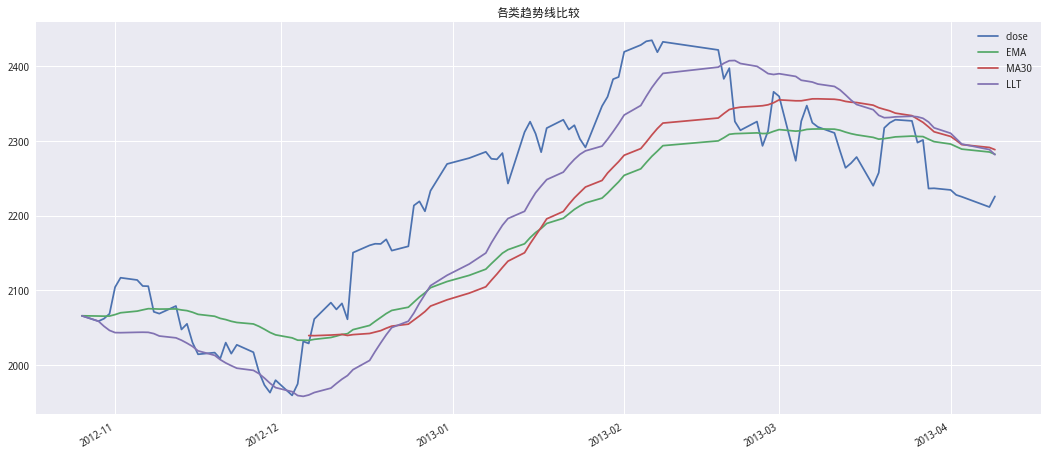

In [5]:
price_df.plot(figsize=(18,8),title='各类趋势线比较')

对于低延迟趋势线 LLT，可以看出，无论$\alpha$取多少，其零频附近的延迟都接近于零；随着频率增大至截止频率，其延迟也都低于 MA 及 EMA 指标。不过 LLT 趋势线仍然具有“$\alpha$越小，延迟越高，平滑性越好”的特点（零频至截止频率一段）。 我们仍然取2012年10月26日至2013年4月9日一段，分别计算$\alpha$参数等于0.03、0.04、0.05 的LLT趋势线

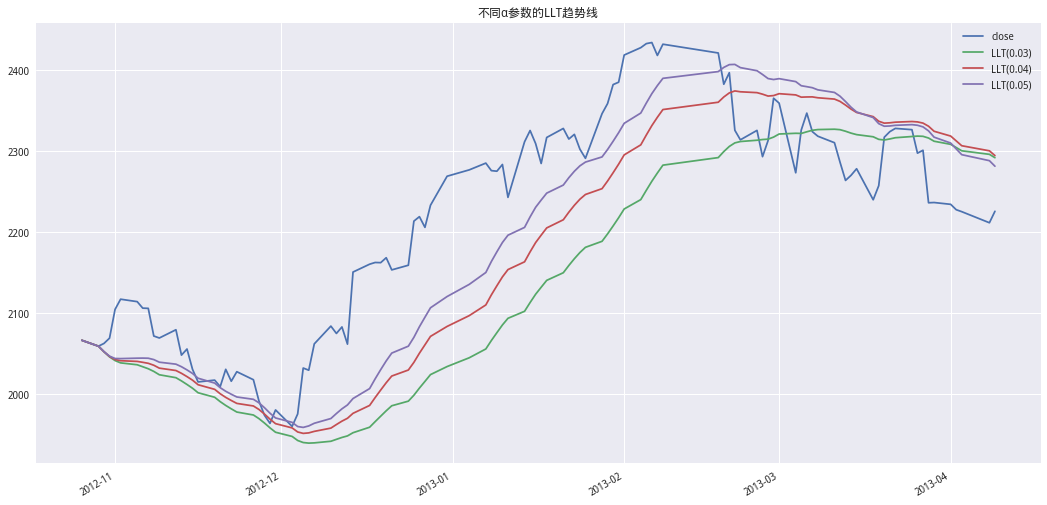

In [6]:
# 丢弃多余列
price_df.drop(columns=['EMA','MA30','LLT'],inplace=True)

for a in [0.03,0.04,0.05]:
    
    price_df[f'LLT(%s)'%a] = cal_LLT(price_df['close'],a)
    
price_df.plot(figsize=(18,9),title='不同α参数的LLT趋势线')   

# 基于 LLT 趋势线的交易性择时

由于 LLT 趋势线中有且仅有参数$\alpha$，因此我们有必要对这一参数进行较为细致的研究。$\alpha$参数等价于 EMA 指标的计算中用到了多少个交易日d 的历史价格数据。因此，我们这里选择d等于20 到 90 的情况（窗口间隔为 10 个交易日），分别计算了多、空双向交易的累积收益情况（未考虑交易成本），回测标的（上证指数）和回测时间（2005年9月6日至2013年6月28日）不变:

<font size=4>$\alpha=\frac{2}{d+1}$</font>

In [7]:
# 获取指数收盘价
price_df = get_price('000300.XSHG','2005-09-06','2013-06-28',fields='close')
# alpha
alpha_all = [2/(d+1) for d in range(20,91,10)]

for a in alpha_all:
    price_df[f'LLT(%0.5s)'%a] = cal_LLT(price_df['close'],a)

**采用切线法**:通过向前差分计算，我们可以在每个交易日结束后得到 LLT 趋势线在该点处切线的斜率k。当k>0时，看多市场；当 k<0时，看空市场；当k=0时，维持之前的方向判断。

In [8]:
# 计算llt的差值
## 不同的差分日期期对收益也会有影响
diff_llt = price_df[[f'LLT(%0.5s)'%(2/(d+1)) for d in range(20,91,10)]].diff().shift(1)

# 1为多头，-1为空头
cond = ((diff_llt>0)*1+(diff_llt<0)*-1)
# 计算收益率
ret_sreies = price_df['close'].pct_change()
ret_shape = np.broadcast_to(np.expand_dims(ret_sreies.values,1),diff_llt.shape)
# 计算策略收益
strategy_ret = cond*ret_shape
# 计算净值
strategy_cum = (1+strategy_ret).cumprod()

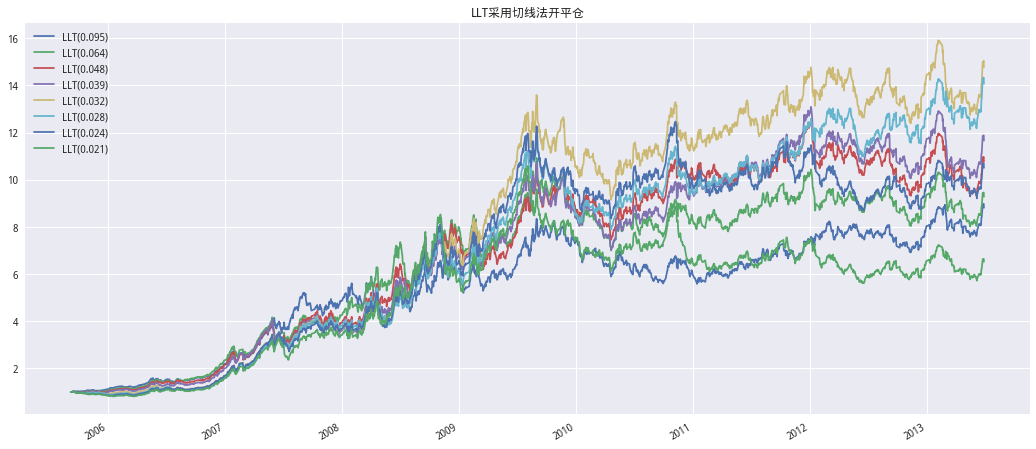

In [9]:
strategy_cum.plot(figsize=(18,8),title='LLT采用切线法开平仓')

<BarContainer object of 8 artists>

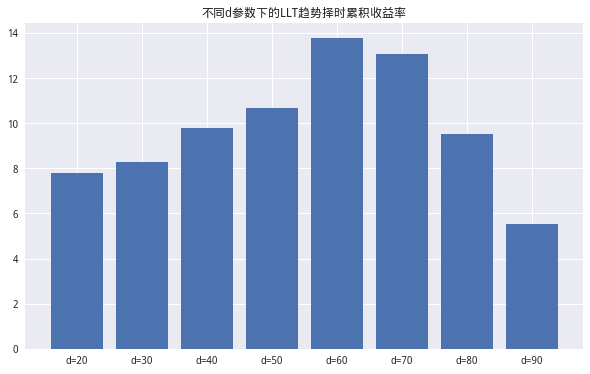

In [10]:
plt.figure(figsize=(10,6))
plt.title('不同d参数下的LLT趋势择时累积收益率')
plt.bar(x=[f'd=%s'%x for x in range(20,91,10)],height=(strategy_cum.iloc[-1]-1).values)

In [11]:
# 计算斜率
def cal_shope(arr):
    
    return np.mean(arr[1:])/np.mean(arr[:-1])

In [12]:
# 计算LLT的每日斜率进行开平仓
shope_df = price_df[[f'LLT(%0.5s)' % (2 / (d + 1)) for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_a = cond * ret_shape
strategy_cum_a = (1 + strategy_ret_a).cumprod()


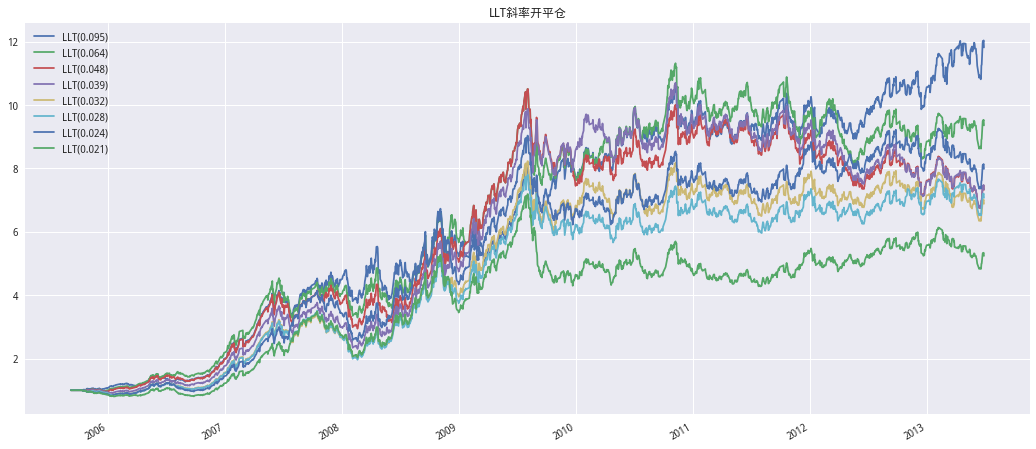

In [13]:
strategy_cum_a.plot(figsize=(18,8),title='LLT斜率开平仓')

<BarContainer object of 8 artists>

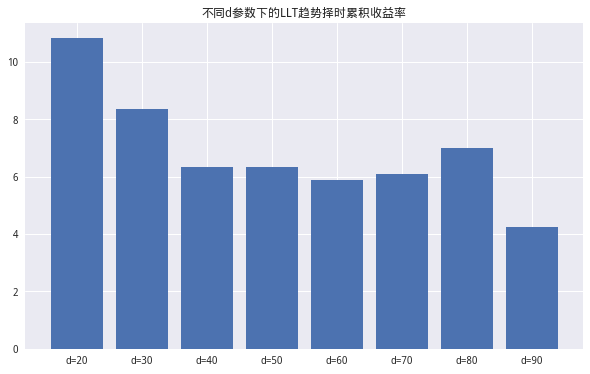

In [14]:
plt.figure(figsize=(10,6))
plt.title('不同d参数下的LLT趋势择时累积收益率')
plt.bar(x=[f'd=%s'%x for x in range(20,91,10)],height=(strategy_cum_a.iloc[-1]-1).values)

净值曲线与研报差异很大，我感觉我对于**切线法**的理解很可能不对.....这里再介绍两个比较不错的滤波方法

# FRAMA均线

分形自适应移动平均（FRactal Adaptive Moving Average，FRAMA）利用了投资品价格序列的分形特征。简单的说，该算法通过一个简单的公式计算从时间序列从当前时点往前2T 长度的时间窗口内的分形维数 D ，并利用分形维数进一步求解指数移动平均的参数 $\alpha$

对于当前时点 t 和给定的窗口 2T，该方法用到了三个时间窗口，即 t 到 t-T+1（记为窗口 W1，长度为 T），t-T 到 t-2T+1（记为窗口 W2，长度为 T），以及 t 到 t-2T+1（记为窗口 W，长度为 2T）。不难看出，W = W1 + W2。FRAMA 的计算过程如下：

FRAMA 的计算过程

1. 用窗口 W1 内的最高价和最低价计算 N1 = (最高价 – 最低价) / T

2. 用窗口 W2 内的最高价和最低价计算 N2 = (最高价 – 最低价) / T

3. 用窗口 W 内的最高价和最低价计算 N3 = (最高价 – 最低价) / (2T)

4. 计算分形维数 D = [log(N1+N2) – log(N3)] / log(2)

5. 计算指数移动平均的参数 alpha = exp(-4.6*(D-1))，并使其满足在 0.01 和 1 之间*

* 随着 alpha 向 1 逼近，指数平滑的衰减加剧，造成移动平均的平滑度大幅下降。因此如果将 alpha 的上限定为 1 可能带来不必要的高频扰动。在实际使用时，可以根据希望达到的最低平滑度来调整 alpha 的上限。在本文后续例子和实验中，如无特殊声明，我们将 alpha 的上限设为 0.2。

6. 将 alpha 带入EMA的公式求解 t 时刻的 FRAMA 移动平均值

$EMA=\begin{cases}
close_t,\quad t=1 \\\\
\alpha*close_t+(1-\alpha)*EMA_{t-1},\quad t>1
\end{cases}$

In [3]:
# 计算FRAMA均线
def FRAMA(se, periods, clip=True):

    T = int(periods/2)
    df = se.copy()

    # 1.用窗口 W1 内的最高价和最低价计算 N1 = (最高价 – 最低价) / T
    N1 = (df.rolling(T).max()-df.rolling(T).min())/T

    # 2.用窗口 W2 内的最高价和最低价计算 N2 = (最高价 – 最低价) / T
    n2_df = df.shift(T)
    N2 = (n2_df.rolling(T).max()-n2_df.rolling(T).min())/T

    # 3.用窗口 T 内的最高价和最低价计算 N3 = (最高价 – 最低价) / (2T)
    N3 = (df.rolling(periods).max() -
          df.rolling(periods).min())/periods

    # 4.计算分形维数 D = [log(N1+N2) – log(N3)] / log(2)
    D = (np.log10(N1+N2)-np.log10(N3))/np.log10(2)

    # 5.计算指数移动平均的参数 alpha = exp(-4.6(D-1))
    alpha = np.exp(-4.6*(D-1))

    # 设置上线
    if clip:
        alpha = np.clip(alpha, 0.01, 0.2)

    FRAMA = []
    idx = min(np.argwhere(~np.isnan(alpha)))-1
    for row, data in enumerate(alpha):
        if row == (idx):
            FRAMA.append(df.iloc[row])
        elif row > (idx):
            FRAMA.append(data*df.iloc[row] +
                         (1-data)*FRAMA[-1])
        else:
            FRAMA.append(np.nan)

    FRAMA_se = pd.Series(FRAMA, index=df.index)

    return FRAMA_se

In [16]:
frama_df = pd.DataFrame()
for d in range(20,91,10):
    frama_df['FRAMA(d=%s)'%d] = FRAMA(price_df['close'],d)

In [17]:
# 计算frama的差值
## 不同的差分日期期对收益也会有影响
diff_frama = frama_df[[f'FRAMA(d=%s)'%d for d in range(20,91,10)]].diff().shift(1)

# 1为多头，-1为空头
cond = ((diff_frama>0)*1+(diff_frama<0)*-1)
# 计算收益率
ret_sreies = price_df['close'].pct_change()
ret_shape = np.broadcast_to(np.expand_dims(ret_sreies.values,1),diff_frama.shape)
# 计算策略收益
strategy_ret_b = cond*ret_shape
# 计算净值
strategy_cum_b = (1+strategy_ret_b).cumprod()

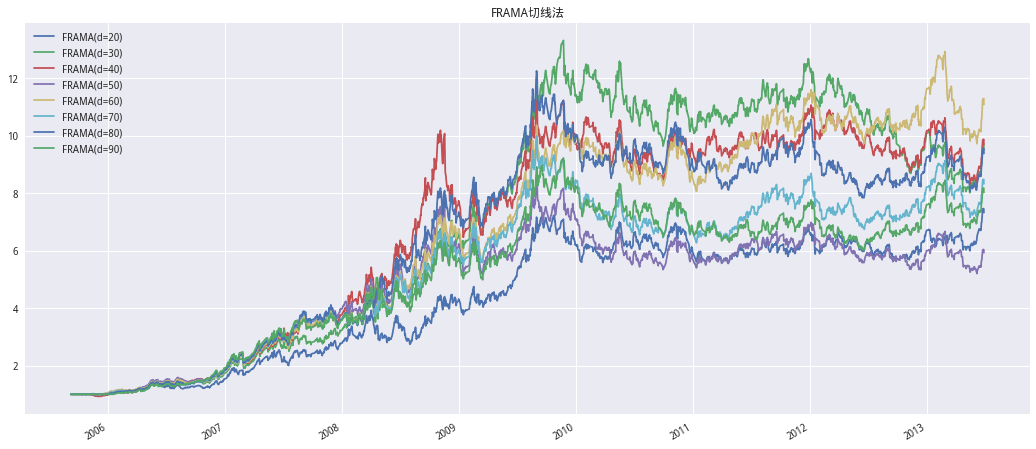

In [18]:
strategy_cum_b.plot(figsize=(18,8),title='FRAMA切线法')

In [19]:
# 计算FRAMA的每日斜率进行开平仓
shope_df = frama_df[[f'FRAMA(d=%s)' % d for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_c = cond * ret_shape
strategy_cum_c = (1 + strategy_ret_c).cumprod()

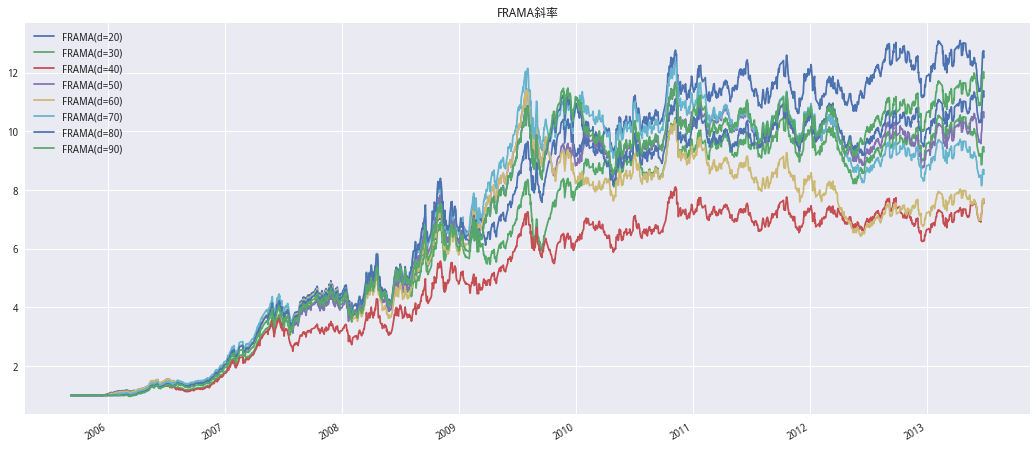

In [20]:
strategy_cum_c.plot(figsize=(18,8),title='FRAMA斜率')

# 赫尔移动平均线

最后，我们再介绍一种业界常用的高级移动平均算法，即**赫尔移动平均（Hull Moving Average，HMA）**。它由 Alan Hull 发明，故由此得名。**该算法最大的特点是在减少滞后的同时有效的提高了均线的平滑程度。**

它的计算步骤。对于给定的窗口T：

1. 计算窗口为T/2的加权移动平均，并把结果乘以 2（如果T/2不是整数则取整）;
2. 计算窗口为T的加权移动平均;
3. 用第1步的结果减去第2部的结果，得到一个新的时间序列;
4. 以第 3 步得到的时间序列为对象，计算窗口为$\sqrt{T}$，的加权移动平均（如果 $\sqrt{T}$不是整数则取整）

上述数学表达式如下:
$$HMA=WMA((2*WMA(x,int(T/2))-WMA(x,T)),int(\sqrt{T})$$

最后，比较T=100时分形自适应移动平均和赫尔移动平均的平滑效果。令人惊喜的看到，**HMA均线有着不输FRAMA均线的灵敏性（滞后性非常低），并且在局部也提高了平滑性，确实做到了在保证平滑性的同时最大的降低了滞后性。**
          

In [27]:
# 构造HMA
def HMA(se, periods):

    close = se.values
    hma = talib.WMA(2*talib.WMA(close, int(periods/2)) -
                    talib.WMA(close, periods), int(sqrt(periods)))

    return pd.Series(hma, index=se.index)

In [28]:
hma_df = pd.DataFrame()
for d in range(20,91,10):
    hma_df['HMA(d=%s)'%d] = HMA(price_df['close'],d)

In [29]:
# 计算hma的差值
## 不同的差分日期期对收益也会有影响
diff_hma = hma_df[[f'HMA(d=%s)'%d for d in range(20,91,10)]].diff().shift(1)

# 1为多头，-1为空头
cond = ((diff_hma>0)*1+(diff_hma<0)*-1)
# 计算收益率
ret_sreies = price_df['close'].pct_change()
ret_shape = np.broadcast_to(np.expand_dims(ret_sreies.values,1),diff_hma.shape)
# 计算策略收益
strategy_ret_d = cond*ret_shape
# 计算净值
strategy_cum_d = (1+strategy_ret_d).cumprod()

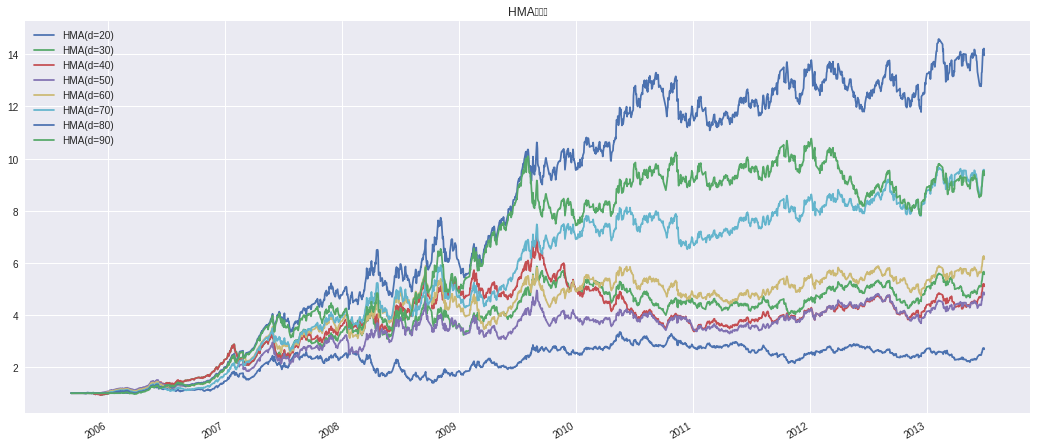

In [30]:
strategy_cum_d.plot(figsize=(18,8),title='HMA切线法')

In [25]:
# 计算HMA的每日斜率进行开平仓
shope_df = hma_df[[f'HMA(d=%s)' % d for d in range(20, 91, 10)
                    ]].rolling(22).apply(
                        cal_shope, raw=True)
                        
cond = (shope_df > 1) * 1 + (shope_df < 1) * -1
strategy_ret_e = cond * ret_shape
strategy_cum_e = (1 + strategy_ret_e).cumprod()

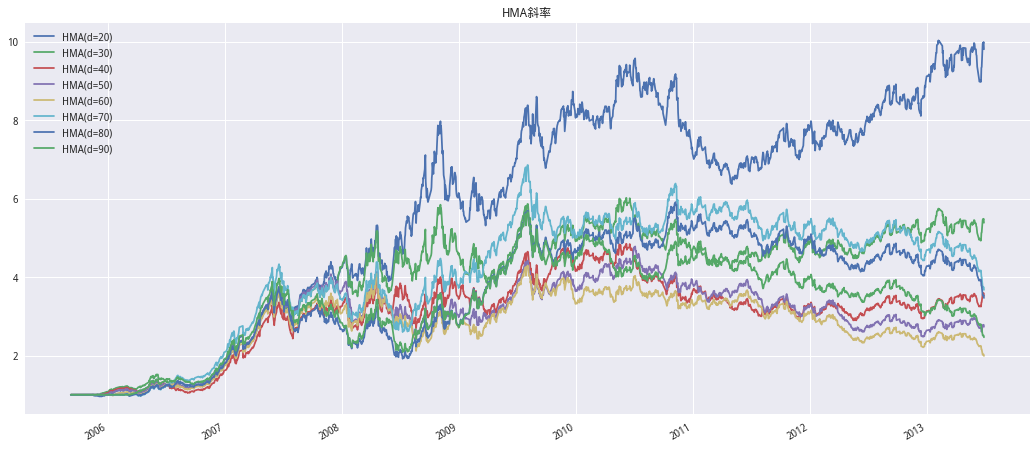

In [26]:
strategy_cum_e.plot(figsize=(18,8),title='HMA斜率')

# 因子合成

将三中均线的差值合成为一个因子,纯多头...

In [55]:
# 获取指数收盘价
price_df = get_price('000300.XSHG','2005-09-06','2013-06-28',fields='close')

In [56]:
llt_df = pd.DataFrame()
frama_df = pd.DataFrame()
hma_df = pd.DataFrame()

for d in range(20,91,10):
    
    llt_df[f'd%s'%d] = cal_LLT(price_df['close'],2/(d+1))
    frama_df[f'd%s'%d] = FRAMA(price_df['close'],d+60)
    hma_df[f'd%s'%d] = HMA(price_df['close'],d+60)

In [57]:
diff_llt = llt_df.diff().shift(1)
diff_llt.index = price_df.index
diff_frama = frama_df.diff().shift(1)
diff_hma = hma_df.diff().shift(1)

In [58]:
x_factor = (diff_llt+diff_frama+diff_hma)/3

cond = (x_factor>0)*1

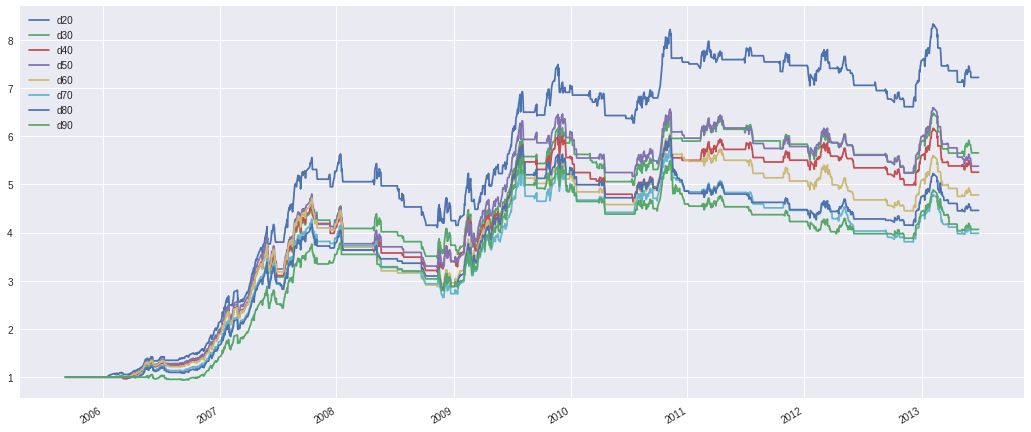

In [59]:
(1+ret_shape*cond).cumprod().plot(figsize=(18,8))

# 调用回测模块

In [2]:
#1 先导入所需要的程序包
import datetime
import numpy as np
import pandas as pd
import time
from jqdata import *
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import itertools
import copy
import pickle

# 定义类'参数分析'
class parameter_analysis(object):
    
    # 定义函数中不同的变量
    def __init__(self, algorithm_id=None):
        self.algorithm_id = algorithm_id            # 回测id
        
        self.params_df = pd.DataFrame()             # 回测中所有调参备选值的内容，列名字为对应修改面两名称，对应回测中的 g.XXXX
        self.results = {}                           # 回测结果的回报率，key 为 params_df 的行序号，value 为
        self.evaluations = {}                       # 回测结果的各项指标，key 为 params_df 的行序号，value 为一个 dataframe
        self.backtest_ids = {}                      # 回测结果的 id
        
        # 新加入的基准的回测结果 id，可以默认为空 ''，则使用回测中设定的基准
        self.benchmark_id = 'f16629492d6b6f4040b2546262782c78'                      
        
        self.benchmark_returns = []                 # 新加入的基准的回测回报率
        self.returns = {}                           # 记录所有回报率
        self.excess_returns = {}                    # 记录超额收益率
        self.log_returns = {}                       # 记录收益率的 log 值
        self.log_excess_returns = {}                # 记录超额收益的 log 值
        self.dates = []                             # 回测对应的所有日期
        self.excess_max_drawdown = {}               # 计算超额收益的最大回撤
        self.excess_annual_return = {}              # 计算超额收益率的年化指标
        self.evaluations_df = pd.DataFrame()        # 记录各项回测指标，除日回报率外
    
    # 定义排队运行多参数回测函数
    def run_backtest(self,                          #
                     algorithm_id=None,             # 回测策略id
                     running_max=10,                # 回测中同时巡行最大回测数量
                     start_date='2006-01-01',       # 回测的起始日期
                     end_date='2016-11-30',         # 回测的结束日期
                     frequency='day',               # 回测的运行频率
                     initial_cash='1000000',        # 回测的初始持仓金额
                     param_names=[],                # 回测中调整参数涉及的变量
                     param_values=[],               # 回测中每个变量的备选参数值
                     python_version = 2,            # 回测的python版本
                     ):
        # 当此处回测策略的 id 没有给出时，调用类输入的策略 id
        if algorithm_id == None: algorithm_id=self.algorithm_id
        
        # 生成所有参数组合并加载到 df 中
        # 包含了不同参数具体备选值的排列组合中一组参数的 tuple 的 list
        param_combinations = list(itertools.product(*param_values))
        # 生成一个 dataframe， 对应的列为每个调参的变量，每个值为调参对应的备选值
        to_run_df = pd.DataFrame(param_combinations)
        # 修改列名称为调参变量的名字
        to_run_df.columns = param_names
        
        # 设定运行起始时间和保存格式
        start = time.time()
        # 记录结束的运行回测
        finished_backtests = {}
        # 记录运行中的回测
        running_backtests = {}
        # 计数器
        pointer = 0
        # 总运行回测数目，等于排列组合中的元素个数
        total_backtest_num = len(param_combinations)
        # 记录回测结果的回报率
        all_results = {}
        # 记录回测结果的各项指标
        all_evaluations = {}
        
        # 在运行开始时显示
        print ('【已完成|运行中|待运行】:'), 
        # 当运行回测开始后，如果没有全部运行完全的话：
        while len(finished_backtests)<total_backtest_num:
            # 显示运行、完成和待运行的回测个数
            print('[%s|%s|%s].' % (len(finished_backtests), 
                                   len(running_backtests), 
                                   (total_backtest_num-len(finished_backtests)-len(running_backtests)) )),
            # 记录当前运行中的空位数量
            to_run = min(running_max-len(running_backtests), total_backtest_num-len(running_backtests)-len(finished_backtests))
            # 把可用的空位进行跑回测
            for i in range(pointer, pointer+to_run):
                # 备选的参数排列组合的 df 中第 i 行变成 dict，每个 key 为列名字，value 为 df 中对应的值
                params = to_run_df.ix[i].to_dict()
                # 记录策略回测结果的 id，调整参数 extras 使用 params 的内容
                backtest = create_backtest(algorithm_id = algorithm_id,
                                           start_date = start_date, 
                                           end_date = end_date, 
                                           frequency = frequency, 
                                           initial_cash = initial_cash, 
                                           extras = params, 
                                           # 再回测中把改参数的结果起一个名字，包含了所有涉及的变量参数值
                                           name = str(params),
                                           python_version = python_version
                                           )
                # 记录运行中 i 回测的回测 id
                running_backtests[i] = backtest
            # 计数器计数运行完的数量    
            pointer = pointer+to_run
            
            # 获取回测结果
            failed = []
            finished = []
            # 对于运行中的回测，key 为 to_run_df 中所有排列组合中的序数
            for key in running_backtests.keys():
                # 研究调用回测的结果，running_backtests[key] 为运行中保存的结果 id
                back_id = running_backtests[key]
                bt = get_backtest(back_id)
                # 获得运行回测结果的状态，成功和失败都需要运行结束后返回，如果没有返回则运行没有结束
                status = bt.get_status()
                # 当运行回测失败
                if status == 'failed':
                    # 失败 list 中记录对应的回测结果 id
                    print ('回测失败 : https://www.joinquant.com/algorithm/backtest/detail?backtestId='+back_id)
                    failed.append(key)
                # 当运行回测成功时
                elif status == 'done':
                    # 成功 list 记录对应的回测结果 id，finish 仅记录运行成功的
                    finished.append(key)
                    # 回测回报率记录对应回测的回报率 dict， key to_run_df 中所有排列组合中的序数， value 为回报率的 dict
                    # 每个 value 一个 list 每个对象为一个包含时间、日回报率和基准回报率的 dict
                    all_results[key] = bt.get_results()
                    # 回测回报率记录对应回测结果指标 dict， key to_run_df 中所有排列组合中的序数， value 为回测结果指标的 dataframe
                    all_evaluations[key] = bt.get_risk()
            # 记录运行中回测结果 id 的 list 中删除失败的运行
            for key in failed:
                running_backtests.pop(key)
            # 在结束回测结果 dict 中记录运行成功的回测结果 id，同时在运行中的记录中删除该回测
            for key in finished:
                finished_backtests[key] = running_backtests.pop(key)
            # 当一组同时运行的回测结束时报告时间
            if len(finished_backtests) != 0 and len(finished_backtests) % running_max == 0 and to_run !=0:
                # 记录当时时间
                middle = time.time()
                # 计算剩余时间，假设没工作量时间相等的话
                remain_time = (middle - start) * (total_backtest_num - len(finished_backtests)) / len(finished_backtests)
                # print 当前运行时间
                print('[已用%s时,尚余%s时,请不要关闭浏览器].' % (str(round((middle - start) / 60.0 / 60.0,3)), 
                                          str(round(remain_time / 60.0 / 60.0,3)))),
            # 5秒钟后再跑一下
            time.sleep(5) 
        # 记录结束时间
        end = time.time() 
        print ('')
        print('【回测完成】总用时：%s秒(即%s小时)。' % (str(int(end-start)), 
                                           str(round((end-start)/60.0/60.0,2)))),
        # 对应修改类内部对应
        self.params_df = to_run_df
        self.results = all_results
        self.evaluations = all_evaluations
        self.backtest_ids = finished_backtests

        
    #7 最大回撤计算方法
    def find_max_drawdown(self, returns):
        # 定义最大回撤的变量
        result = 0
        # 记录最高的回报率点
        historical_return = 0
        # 遍历所有日期
        for i in range(len(returns)):
            # 最高回报率记录
            historical_return = max(historical_return, returns[i])
            # 最大回撤记录
            drawdown = 1-(returns[i] + 1) / (historical_return + 1)
            # 记录最大回撤
            result = max(drawdown, result)
        # 返回最大回撤值
        return result

    # log 收益、新基准下超额收益和相对与新基准的最大回撤
    def organize_backtest_results(self, benchmark_id=None):
        # 若新基准的回测结果 id 没给出
        if benchmark_id==None:
            # 使用默认的基准回报率，默认的基准在回测策略中设定
            self.benchmark_returns = [x['benchmark_returns'] for x in self.results[0]]
        # 当新基准指标给出后    
        else:
            # 基准使用新加入的基准回测结果
            self.benchmark_returns = [x['returns'] for x in get_backtest(benchmark_id).get_results()]
        # 回测日期为结果中记录的第一项对应的日期
        self.dates = [x['time'] for x in self.results[0]]
        
        # 对应每个回测在所有备选回测中的顺序 （key），生成新数据
        # 由 {key：{u'benchmark_returns': 0.022480100091729405,
        #           u'returns': 0.03184566700000002,
        #           u'time': u'2006-02-14'}} 格式转化为：
        # {key: []} 格式，其中 list 为对应 date 的一个回报率 list
        for key in self.results.keys():
            self.returns[key] = [x['returns'] for x in self.results[key]]
        # 生成对于基准（或新基准）的超额收益率
        for key in self.results.keys():
            self.excess_returns[key] = [(x+1)/(y+1)-1 for (x,y) in zip(self.returns[key], self.benchmark_returns)]
        # 生成 log 形式的收益率
        for key in self.results.keys():
            self.log_returns[key] = [log(x+1) for x in self.returns[key]]
        # 生成超额收益率的 log 形式
        for key in self.results.keys():
            self.log_excess_returns[key] = [log(x+1) for x in self.excess_returns[key]]
        # 生成超额收益率的最大回撤
        for key in self.results.keys():
            self.excess_max_drawdown[key] = self.find_max_drawdown(self.excess_returns[key])
        # 生成年化超额收益率
        for key in self.results.keys():
            self.excess_annual_return[key] = (self.excess_returns[key][-1]+1)**(252./float(len(self.dates)))-1
        # 把调参数据中的参数组合 df 与对应结果的 df 进行合并
        
        self.evaluations_df = pd.concat([self.params_df, pd.DataFrame(self.evaluations).T], axis=1)
        #self.evaluations_df = 

    # 获取最总分析数据，调用排队回测函数和数据整理的函数    
    def get_backtest_data(self,
                          algorithm_id=None,                         # 回测策略id
                          benchmark_id=None,                         # 新基准回测结果id
                          file_name='results.pkl',                   # 保存结果的 pickle 文件名字
                          running_max=10,                            # 最大同时运行回测数量
                          start_date='2006-01-01',                   # 回测开始时间
                          end_date='2016-11-30',                     # 回测结束日期
                          frequency='day',                           # 回测的运行频率
                          initial_cash='1000000',                    # 回测初始持仓资金
                          param_names=[],                            # 回测需要测试的变量
                          param_values=[],                           # 对应每个变量的备选参数
                          python_version = 2
                          ):
        # 调运排队回测函数，传递对应参数
        self.run_backtest(algorithm_id=algorithm_id,
                          running_max=running_max,
                          start_date=start_date,
                          end_date=end_date,
                          frequency=frequency,
                          initial_cash=initial_cash,
                          param_names=param_names,
                          param_values=param_values,
                          python_version = python_version
                          )
        # 回测结果指标中加入 log 收益率和超额收益率等指标
        self.organize_backtest_results(benchmark_id)
        # 生成 dict 保存所有结果。
        results = {'returns':self.returns,
                   'excess_returns':self.excess_returns,
                   'log_returns':self.log_returns,
                   'log_excess_returns':self.log_excess_returns,
                   'dates':self.dates,
                   'benchmark_returns':self.benchmark_returns,
                   'evaluations':self.evaluations,
                   'params_df':self.params_df,
                   'backtest_ids':self.backtest_ids,
                   'excess_max_drawdown':self.excess_max_drawdown,
                   'excess_annual_return':self.excess_annual_return,
                   'evaluations_df':self.evaluations_df}
        # 保存 pickle 文件
        pickle_file = open(file_name, 'wb')
        pickle.dump(results, pickle_file)
        pickle_file.close()

    # 读取保存的 pickle 文件，赋予类中的对象名对应的保存内容    
    def read_backtest_data(self, file_name='results.pkl'):
        pickle_file = open(file_name, 'rb')
        results = pickle.load(pickle_file)
        self.returns = results['returns']
        self.excess_returns = results['excess_returns']
        self.log_returns = results['log_returns']
        self.log_excess_returns = results['log_excess_returns']
        self.dates = results['dates']
        self.benchmark_returns = results['benchmark_returns']
        self.evaluations = results['evaluations']
        self.params_df = results['params_df']
        self.backtest_ids = results['backtest_ids']
        self.excess_max_drawdown = results['excess_max_drawdown']
        self.excess_annual_return = results['excess_annual_return']
        self.evaluations_df = results['evaluations_df']
        
    # 回报率折线图    
    def plot_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.returns[key])), self.returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), self.benchmark_returns, label='benchmark', c='k', linestyle='--') 
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.returns[0]))

    # 超额收益率图    
    def plot_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.excess_returns[key])), self.excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('excess returns',fontsize=20)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.excess_returns[0]))
        
    # log回报率图    
    def plot_log_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_returns[key])), self.log_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [log(x+1) for x in self.benchmark_returns], label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_returns[0]))
    
    # 超额收益率的 log 图
    def plot_log_excess_returns(self):
        # 通过figsize参数可以指定绘图对象的宽度和高度，单位为英寸；
        fig = plt.figure(figsize=(20,8))
        ax = fig.add_subplot(111)
        # 作图
        for key in self.returns.keys():
            ax.plot(range(len(self.log_excess_returns[key])), self.log_excess_returns[key], label=key)
        # 设定benchmark曲线并标记
        ax.plot(range(len(self.benchmark_returns)), [0]*len(self.benchmark_returns), label='benchmark', c='k', linestyle='--')
        ticks = [int(x) for x in np.linspace(0, len(self.dates)-1, 11)]
        plt.xticks(ticks, [self.dates[i] for i in ticks])
        # 设置图例样式
        ax.legend(loc = 2, fontsize = 10)
        # 设置y标签样式
        ax.set_ylabel('log excess returns',fontsize=20)
        # 设置图片标题样式
        ax.set_title("Strategy's performances with different parameters", fontsize=21)
        plt.xlim(0, len(self.log_excess_returns[0]))

        
    # 回测的4个主要指标，包括总回报率、最大回撤夏普率和波动
    def get_eval4_bar(self, sort_by=[]): 
        
        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        fig = plt.figure(figsize=(20,7))

        # 定义位置
        ax1 = fig.add_subplot(221)
        # 设定横轴为对应分位，纵轴为对应指标
        ax1.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_return'] for x in indices], 0.6, label = 'Algorithm_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax1.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax1.set_ylabel('Algorithm_return', fontsize=15)
        # 设置y标签样式
        ax1.set_yticklabels([str(x*100)+'% 'for x in ax1.get_yticks()])
        # 设置图片标题样式
        ax1.set_title("Strategy's of Algorithm_return performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax2 = fig.add_subplot(224)
        # 设定横轴为对应分位，纵轴为对应指标
        ax2.bar(range(len(indices)), 
                [self.evaluations[x]['max_drawdown'] for x in indices], 0.6, label = 'Max_drawdown')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax2.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax2.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax2.set_yticklabels([str(x*100)+'% 'for x in ax2.get_yticks()])
        # 设置图片标题样式
        ax2.set_title("Strategy's of Max_drawdown performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax3 = fig.add_subplot(223)
        # 设定横轴为对应分位，纵轴为对应指标
        ax3.bar(range(len(indices)),
                [self.evaluations[x]['sharpe'] for x in indices], 0.6, label = 'Sharpe')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax3.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax3.set_ylabel('Sharpe', fontsize=15)
        # 设置x标签样式
        ax3.set_yticklabels([str(x*100)+'% 'for x in ax3.get_yticks()])
        # 设置图片标题样式
        ax3.set_title("Strategy's of Sharpe performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))

        # 定义位置
        ax4 = fig.add_subplot(222)
        # 设定横轴为对应分位，纵轴为对应指标
        ax4.bar(range(len(indices)), 
                [self.evaluations[x]['algorithm_volatility'] for x in indices], 0.6, label = 'Algorithm_volatility')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax4.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax4.set_ylabel('Algorithm_volatility', fontsize=15)
        # 设置x标签样式
        ax4.set_yticklabels([str(x*100)+'% 'for x in ax4.get_yticks()])
        # 设置图片标题样式
        ax4.set_title("Strategy's of Algorithm_volatility performances of different quantile", fontsize=15)
        # x轴范围
        plt.xlim(0, len(indices))
        
    #14 年化回报和最大回撤，正负双色表示
    def get_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.evaluations[x]['max_drawdown'] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Max_drawdown', zorder=10)
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.evaluations[x]['annual_algo_return'] for x in indices], color = 'r', 
                     width = 0.6, label = 'Annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))


    #14 超额收益的年化回报和最大回撤
    # 加入新的benchmark后超额收益和
    def get_excess_eval(self, sort_by=[]):

        sorted_params = self.params_df
        for by in sort_by:
            sorted_params = sorted_params.sort(by)
        indices = sorted_params.index
        
        # 大小
        fig = plt.figure(figsize = (20, 8))
        # 图1位置
        ax = fig.add_subplot(111)
        # 生成图超额收益率的最大回撤
        ax.bar([x+0.3 for x in range(len(indices))],
               [-self.excess_max_drawdown[x] for x in indices], color = '#32CD32',  
                     width = 0.6, label = 'Excess_max_drawdown')
        # 图年化超额收益
        ax.bar([x for x in range(len(indices))],
               [self.excess_annual_return[x] for x in indices], color = 'r', 
                     width = 0.6, label = 'Excess_annual_return')
        plt.xticks([x+0.3 for x in range(len(indices))], indices)
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 基准线
        plt.plot([0, len(indices)], [0, 0], c='k', 
                 linestyle='--', label='zero')
        # 设置图例样式
        ax.legend(loc='best',fontsize=15)
        # 设置y标签样式
        ax.set_ylabel('Max_drawdown', fontsize=15)
        # 设置x标签样式
        ax.set_yticklabels([str(x*100)+'% 'for x in ax.get_yticks()])
        # 设置图片标题样式
        ax.set_title("Strategy's performances of different quantile", fontsize=15)
        #   设定x轴长度
        plt.xlim(0, len(indices))

In [3]:
#2 设定回测的 策略id 
# 克隆策略后填入 策略id
pa = parameter_analysis('bacbec17467c15d7b2c8427f9f387de9')

## LLT

In [18]:
#3 运行回测
pa.get_backtest_data(file_name = 'results.pkl',  # 保存回测结果的Pickle文件名
                          running_max = 10,      # 同时回测的最大个数,可以通过积分商城兑换
                          benchmark_id = None,   # 基准的回测ID,注意是回测ID而不是策略ID,为None时为策略中使用的基准
                          start_date = '2010-01-01', #回测开始时间
                          end_date = '2019-12-31',   #回测结束时间
                          frequency = 'day',         #回测频率,支持 day, minute, tick 
                          initial_cash = '20000000',  #初始资金
                          param_names = ['MA_NAME','WINDOW'],  #变量名称
                          param_values = [['LLT'],[20.]],  #变量对应的参数
                          python_version = 3
                          )

【已完成|运行中|待运行】:
[0|0|1].


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:91: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].
[0|1|0].

【回测完成】总用时：59秒(即0.02小时)。


In [26]:
#4 数据读取
pa.read_backtest_data('results.pkl')

In [27]:
#5 回测参数的 Dataframe
pa.params_df

,MA_NAME,WINDOW
0,LLT,20.0


In [28]:
#6 查看回测结果指标
pa.evaluations_df.T

,0
MA_NAME,LLT
WINDOW,20
__version,101
algorithm_return,-0.122723
algorithm_volatility,0.155461
alpha,-0.0416053
annual_algo_return,-0.0133746
annual_bm_return,0.014084
avg_excess_return,-5.11575e-05
benchmark_return,0.145679


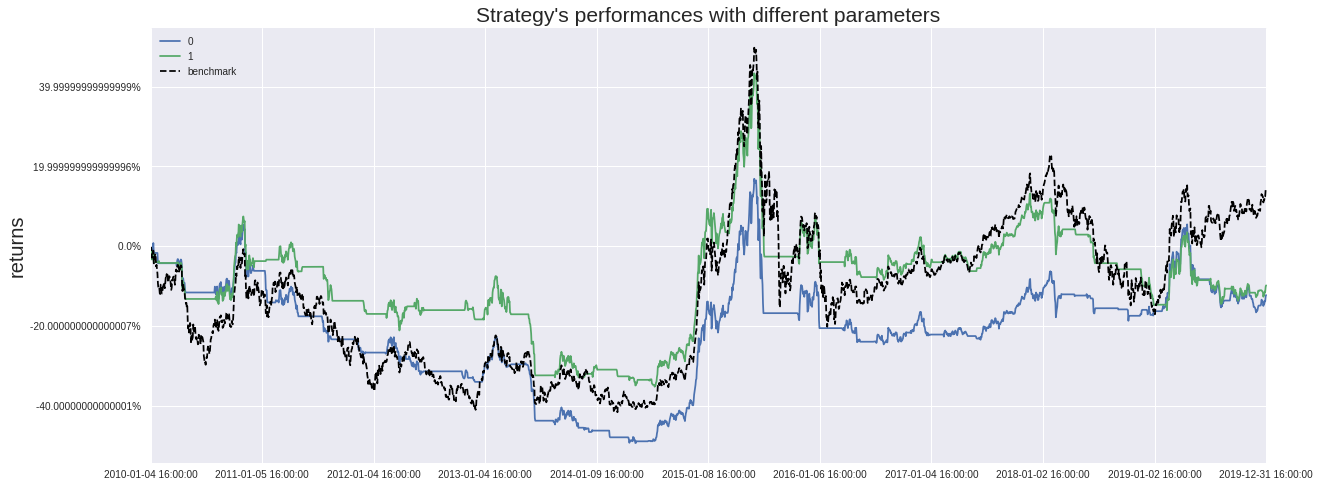

In [29]:
 #7 回报率折线图    
pa.plot_returns()